#### 自动编码器（autoencoder，AE）是一种最基础的无监督特征提取方法。

它将一个输入的数据压缩成一个低维度的特征向量表示，然后试图把这个数据回复原样（结果通常不会与原结果完全相同）

- 编码器(encoder) 将一个高维的特征压缩成低维
- 解码器(decoder) 将低维的特征回复成原始样本

在PCA算法中，我们通过矩阵分解提取出了使样本方差最大的个主成分。然而，当样本数量或者样本维度较大时，PCA的计算复杂度非常高。

并且如果样本的有效特征并非样本当前维度的线性组合，而是要经过非线性变换才能得到，那么PCA算法就无能为力了。

为了解决这一问题，我们可以用神经网络中的非线性激活函数来引入非线性成分。利用神经网络强大的函数拟合能力，我们就可以近似任意的非线性变换，从而得到质量较高的样本特征。




In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

### 导入数据

#### 介绍一下 mnist数据集：
label, pixel_0, pixel_1, ..., pixel_783
 - 第一列是标签（数字的真实值，0~9）；
 - 后续 784 列是像素值（对应 28x28 图像的每个像素点，范围 0~255）。

In [21]:
mnist_train = pd.read_csv('mnist_train.csv')
mnist_test = pd.read_csv('mnist_test.csv')

x_train = mnist_train.iloc[:,1:].to_numpy().reshape(-1,28*28) /255  #表示选取所有行、从第 1 列开始到最后的所有列（去掉第一列 label ）；
x_test = mnist_test.iloc[:,1:].to_numpy().reshape(-1,28*28) /255 

print("训练集大小:",len(x_train))
print("测试集大小",len(x_test))


训练集大小: 60000
测试集大小 10000


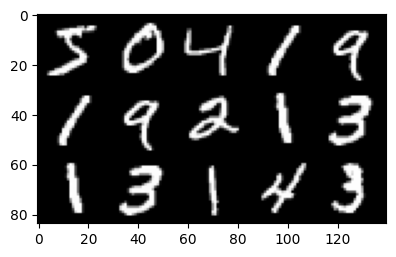

In [22]:
#data 图像像素数据，每一行代表一张图片
#m,n 展示前m，n行数据
def display(data,m,n):
    img=np.zeros((28*m,28*n))
    for i in range(m):
        for j in range(n):
            img[i*28:(i+1)*28,j*28:(j+1)*28]= \
            data[i*m+j].reshape((28,28))
    
    plt.figure(figsize=(m*1.5,n*1.5))
    plt.imshow(img,cmap='gray')
    plt.show()


display(x_train,3,5)

### 多层感知机


In [24]:
class MLP(nn.Module):
    
    def __init__(self,layer_sizes):
        super().__init__()
        self.layers=nn.ModuleList()
        num_in =layer_sizes[0]
        for num_out in layer_sizes[1:] :
            #加入全连接层
            self.layers.append(nn.Linear(num_in,num_out))
            #加入激活函数
            self.layers.append(nn.Sigmoid())
            num_in=num_out
    
    def forward(self,x):
        for l in self.layers:
            x=l(x)
        return x

layer_sizes=[784,256,128,100]
encoder=MLP(layer_sizes)
decoder=MLP(layer_sizes[::-1]) #解码器的各层大小与编码器相反

训练轮数：0，平均损失：0.0313


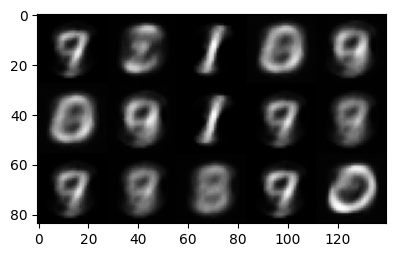

训练轮数：2，平均损失：0.0163


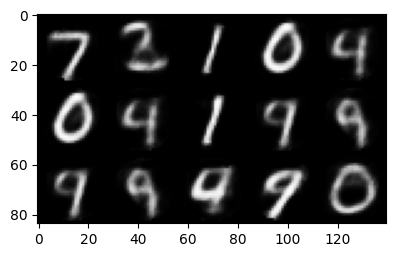

训练轮数：4，平均损失：0.0114


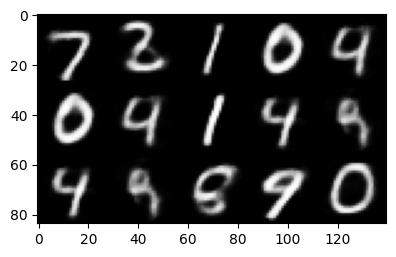

训练轮数：6，平均损失：0.0092


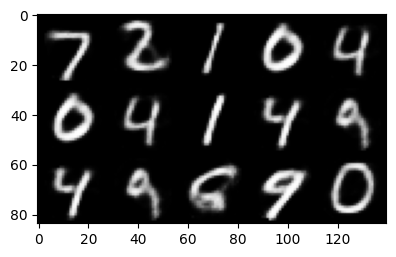

训练轮数：8，平均损失：0.0076


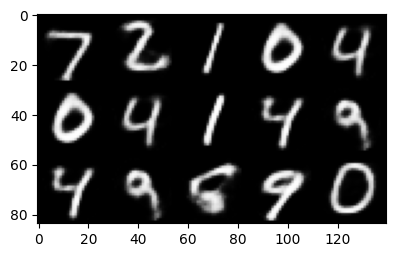

训练轮数：9，平均损失：0.0070


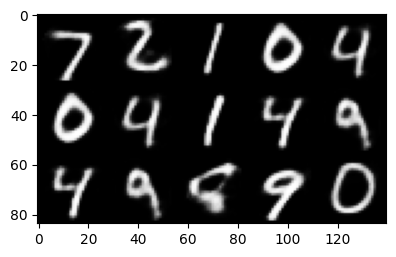

In [ ]:
# 训练超参数
learning_rate =0.01 # 学习率
max_epoch = 10 # 训练轮数
batch_size = 256 #批量大小
display_step = 2 #表示图片展示的间隔

np.random.seed(0)
torch.manual_seed(0)

#采用Adam优化器，解码器和编码器的参数共同优化
optimizer=torch.optim.Adam(list(encoder.parameters())+list(decoder.parameters()),lr=learning_rate)

#开始训练

for i in range(max_epoch):
    #打乱样本
    idx=np.arange(len(x_train))
    idx=np.random.permutation(idx)
    x_train=x_train[idx]
    st=0
    ave_loss=[]
    while st<len(x_train):

        ed=min(st+batch_size,len(x_train))
        X=torch.from_numpy(x_train[st:ed]).to(torch.float32)
        Z=encoder(X)
        X_rec=decoder(Z)

        loss=0.5*nn.functional.mse_loss(X,X_rec) #重建损失
        ave_loss.append(loss.item())
        # 梯度清零
        optimizer.zero_grad()
        # 反向传播
        loss.backward()
        # 参数更新
        optimizer.step()
        st=ed
    
    ave_loss=np.average(ave_loss)

    if i% display_step==0 or i==max_epoch-1 :
        print(f'训练轮数：{i}，平均损失：{ave_loss:.4f}')
        #选取测试集中的部分图像重建并展示
        #推理模式”下运行，不需要计算梯度
        with torch.inference_mode():
            X_test=torch.from_numpy(x_test[:3*5]).to(torch.float32)     
            X_test_rec=decoder(encoder(X_test))
            X_test_rec=X_test_rec.cpu().numpy() #将重构结果从 GPU（如果有的话）转移到 CPU，并转换为 NumPy 数组。
        
        display(X_test_rec,3,5)



原始图像


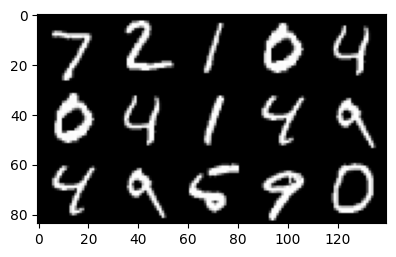

重建图像


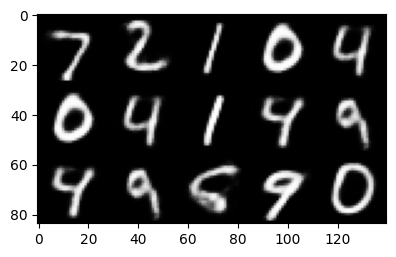

In [18]:
print('原始图像')
display(x_test, 3, 5)

print('重建图像')
X_test = torch.from_numpy(x_test[:3 * 5]).to(torch.float32)
X_test_rec = decoder(encoder(X_test))
X_test_rec = X_test_rec.detach().cpu().numpy()
display(X_test_rec, 3, 5)